In [1]:
!pip install panelsplit

In [2]:
from sklearn.model_selection import KFold, TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from panelsplit.cross_validation import PanelSplit
from functools import reduce

# (1) Train-test splits

The objective of this section is to show how we can construct a valid set of (train, test) splits in the case of cross-sectional, time-series and panel data.

## a) Cross-sectional

In [3]:
#make some dummy data
countries = pd.Index([f"c_{x}" for x in np.arange(1, 51)])

In [4]:
kf = KFold(n_splits=5)

for i, (train_indices, test_indices) in enumerate(kf.split(countries)):
  print(f"Fold: {i}")
  print(f"Train countries: {countries[train_indices]}")
  print(f"Test countries: {countries[test_indices]}")

Fold: 0
Train countries: Index(['c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17', 'c_18', 'c_19',
       'c_20', 'c_21', 'c_22', 'c_23', 'c_24', 'c_25', 'c_26', 'c_27', 'c_28',
       'c_29', 'c_30', 'c_31', 'c_32', 'c_33', 'c_34', 'c_35', 'c_36', 'c_37',
       'c_38', 'c_39', 'c_40', 'c_41', 'c_42', 'c_43', 'c_44', 'c_45', 'c_46',
       'c_47', 'c_48', 'c_49', 'c_50'],
      dtype='object')
Test countries: Index(['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10'], dtype='object')
Fold: 1
Train countries: Index(['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10',
       'c_21', 'c_22', 'c_23', 'c_24', 'c_25', 'c_26', 'c_27', 'c_28', 'c_29',
       'c_30', 'c_31', 'c_32', 'c_33', 'c_34', 'c_35', 'c_36', 'c_37', 'c_38',
       'c_39', 'c_40', 'c_41', 'c_42', 'c_43', 'c_44', 'c_45', 'c_46', 'c_47',
       'c_48', 'c_49', 'c_50'],
      dtype='object')
Test countries: Index(['c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17', 'c_18', 'c_19

Things you should notice:
- There is no time dimension here. Any of the above splits would be a valid way to split your data into train and test.

Try:
  - Changing `n_splits` and inspecting the lengths of `train_indices` and `test_indices`. How are n_splits and these lengths related?

## b) Time-series

In [5]:
#make some dummy data
timesteps = pd.Index(pd.date_range(start="2021-01-01", periods=36, freq="MS").strftime("%Y%m"))

In [8]:
n_splits = 12 #how many splits
test_size = 1 #how many timesteps in the test set for each split
tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=2) #sklearn TimeSeriesSplit object

splits = []
for i, (train_indices, test_indices) in enumerate(tss.split(timesteps)):
  print(f"Split: {i+1}")
  print(f"Train timesteps: {timesteps[train_indices]}")
  print(f"Timesteps: {timesteps[test_indices]}")
  splits.append((timesteps[train_indices], timesteps[test_indices]))


Split: 1
Train timesteps: Index(['202101', '202102', '202103', '202104', '202105', '202106', '202107',
       '202108', '202109', '202110', '202111', '202112', '202201', '202202',
       '202203', '202204', '202205', '202206', '202207', '202208', '202209',
       '202210'],
      dtype='object')
Timesteps: Index(['202301'], dtype='object')
Split: 2
Train timesteps: Index(['202101', '202102', '202103', '202104', '202105', '202106', '202107',
       '202108', '202109', '202110', '202111', '202112', '202201', '202202',
       '202203', '202204', '202205', '202206', '202207', '202208', '202209',
       '202210', '202211'],
      dtype='object')
Timesteps: Index(['202302'], dtype='object')
Split: 3
Train timesteps: Index(['202101', '202102', '202103', '202104', '202105', '202106', '202107',
       '202108', '202109', '202110', '202111', '202112', '202201', '202202',
       '202203', '202204', '202205', '202206', '202207', '202208', '202209',
       '202210', '202211', '202212'],
      dtype

<ipython-input-9-606ba3ccbb72>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


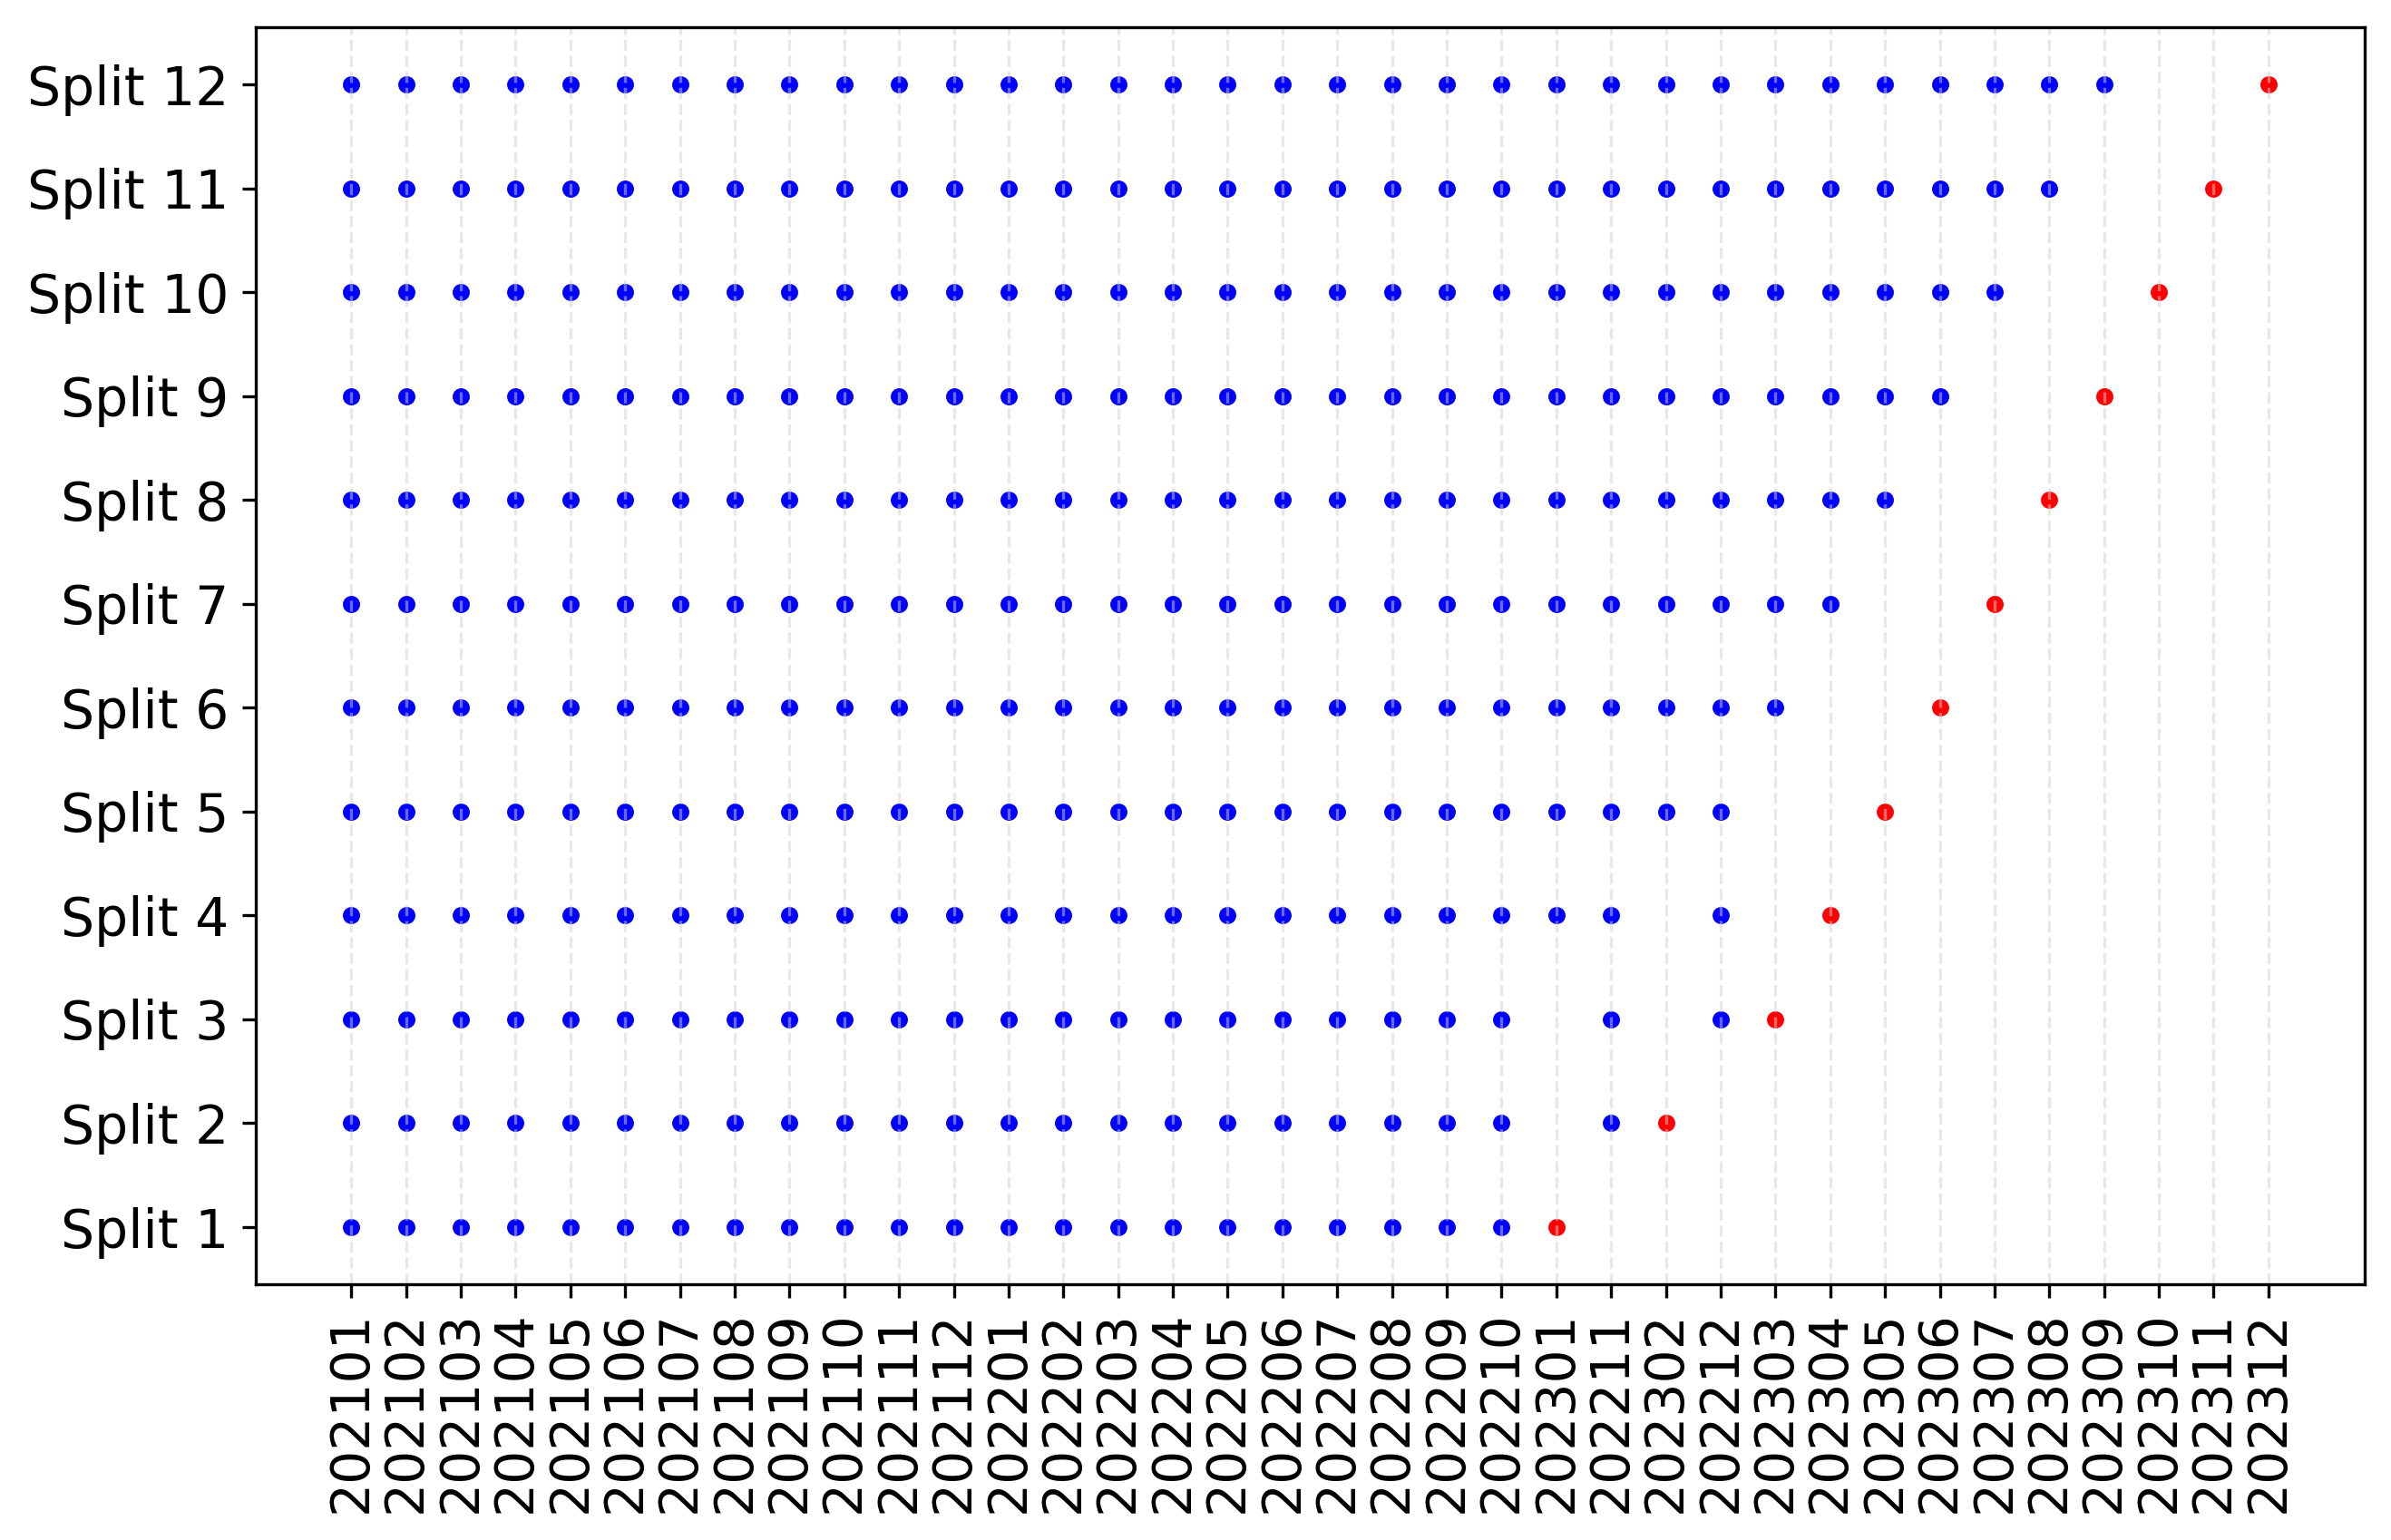

In [9]:
#plot each split

fig, ax = plt.subplots(figsize=(10, 6), dpi = 300)

for i, (train_index, test_index) in enumerate(splits):
        ax.scatter(train_index, [i] * len(train_index), color='blue', marker='.', s=50)
        ax.scatter(test_index, [i] * len(test_index), color='red', marker='.', s=50)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticks(range(len(splits)))  # Set the number of ticks on the y-axis
ax.set_yticklabels([f'Split {i}' for i in np.arange(1, len(splits)+1)])  # Set custom labels for the y-axis
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(axis='x', which='major', linestyle='--', color='lightgray', alpha=0.5)

Things you should notice:
- We have a time dimension now. To generate valid predictions (i.e. no data leakage), we must iteratively train on all available data and predict the next timestamp. This is called "pseudo-out-of-sample" forecasting.
- Since we have 12 splits, we will also have 12 fitted estimators.

Try:
  - Changing `n_splits` and `test_size`, whilst holding `test_size`=36. Do you notice any errors? Why?

Bonus:
- There is a `gap` parameter in TimeSeriesSplit. Read the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) and then try out different configurations of `periods`, `n_splits`, `test_size`, and `gap`. If you can develop intutions here, then you are well on your way!

In [ ]:
#create a multiindex of all countries and timesteps
panel_index = pd.MultiIndex.from_product([countries, timesteps], names=['country', 'timestep'])
panel_index

 ## c) Panel data

In [ ]:
n_splits = 12
test_size = 1
panel_split = PanelSplit(
    periods = panel_index.get_level_values('timestep'),
    n_splits=n_splits,
    test_size=test_size
)

In [ ]:
#check the indices of the splits
for i, (train_indices, test_indices) in enumerate(panel_split._u_periods_cv):
  print(f"Split: {i+1}")
  print(f"Train indices: {train_indices}")
  print(f"Test indices: {test_indices}")

In [ ]:
#check how the splits look in the context of our multiindex
#check the indices of the splits
for i, (train_indices, test_indices) in enumerate(panel_split._u_periods_cv):
  print(f"Split: {i+1}")
  print(f"Train indices: {panel_index[panel_index.get_level_values('timestep').isin(train_indices)]}")
  print(f"Test indices: {panel_index[panel_index.get_level_values('timestep').isin(test_indices)]}")

Things you should notice:
- Now we have a unit (country) and time dimension! But the outcome is the same as the time-series case - we only split (train, test) pairs according to the time dimension.
- The only difference is that each blue dot in the figure will contain 200 countries, not just 1.

Try:
  - Reading the source code at https://github.com/4Freye/panelsplit/blob/main/panelsplit/cross_validation.py. You will notice `n_splits`, `test_size`, and `gap` all appear again. Have a play around with changing these values. Also, check out the attributes of PanelSplit class to improve your understanding (top tip: `dir(panel_split)` to see all attributes and methods associated with the initialised class).

# 2) Target variables

The objective of this section is to understand how to generate target variables for:

1.   Incidence
2.   Onset

You will also learn how your choice of horizon impacts their definition.

In [ ]:
#NB - upload the ucdp.csv file into files (toggle on the left-hand side). You will need to do this for any given run of the notebook.
#alternatively upload to your G Drive and mount your drive in this notebook
import os
os.listdir()

In [ ]:
#read the data
ucdp = pd.read_csv("ucdp.csv")
ucdp = ucdp.set_index(['isocode', 'period']).sort_index() #set index to our id_vars and sort values

#note: sorting values is CRITICAL when using group by operations
ucdp

In [ ]:
#no need for population for demonstration. Keep it if you want a per capita target definition.
ucdp = ucdp.drop(columns=["population"])
ucdp['fatalities_UCDP'] = ucdp['fatalities_UCDP'].astype(int)
#rename column for convenience
ucdp = ucdp.rename(columns={"fatalities_UCDP": "violence"})

In [ ]:
class TargetEngineer():

  """
  Class to generate target variables for incidence and onset under a given horizon.

  Args
  ----

  df: pd.DataFrame
    Dataframe with at least columns that include [unit, time, y_col]

  unit: str
    Column that defines your unit. E.g. 'isocode'

  time: str
    Column that defines your time. E.g. 'period'

  y_col: str
    Column that defines your y variable. E.g. 'violence'
  """

  def __init__(self, df:pd.DataFrame, unit:str, time:str, y_col:str):

    self.df = df.copy()
    self.unit = unit
    self.time = time
    self.y_col = y_col

  def any(self, threshold:int):

    """
    Function to compute "any" variable.

    Args
    ----

    threshold: int
      Threshold to apply to self.y_col.

    Returns
    -------

    pd.DataFrame
      Dataframe with any variable.

    str
      Name of the any variable.
    """

    any_col = f"any{self.y_col}_th{threshold}"
    self.df[any_col] = (self.df[self.y_col] > threshold).astype(int)
    return self.df.copy(), any_col

  def incidence(self, threshold:int, horizon:int):

    """
    Function to compute incidence target variable based on the specific threshold and horizon.

    Args
    ----

    threshold: int
      Threshold to apply to self.y_col.

    horizon: int
      Forecasting horizon (assumes aggregated window).

    Returns
    -------

    pd.DataFrame
      Dataframe with y_col, any_col, and target_col.
    """

    #make the any variable
    df, any_col = self.any(threshold)

    #get the rolling max value of your any variable over the specified horizon
    any_col_max = f"{any_col}_max"
    df[any_col_max] = self.df.groupby(self.unit)[any_col]. \
            transform(lambda x: x.rolling(window=horizon, min_periods = horizon).max())

    #shift any_col_max by the specified horizon to get your incidence target variable
    target_col = f"inc_{any_col}_h{horizon}"
    df[target_col] = df.groupby(self.unit)[any_col_max].transform(lambda x: x.shift(-horizon))

    return df[[self.y_col, any_col, target_col]]

  def onset(self, threshold:int, horizon:int):

    """
    Function to compute onset target variable based on the specific threshold and horizon.

    Args
    ----

    threshold: int
      Threshold to apply to self.y_col.

    horizon: int
      Forecasting horizon (assumes aggregated window).

    Returns
    -------

    pd.DataFrame
      Dataframe with y_col, any_col, and target_col.
    """

    #make the any variable
    df, any_col = self.any(threshold)

    def _onset(x:pd.Series, h:int):

      """
      Function to compute onset target variable for a single unit

      Args
      ---

      x: pd.Series
        The "any" variable for a single unit.

      h: int
        Forecasting horizon (assumes aggregated window).

      Returns
      -------

      pd.Series
        The onset target variable for a single unit.
      """

      index = x.index #get the index
      x = list(x) #convert to list
      y = [] #empty list for storing the onset target
      for i in range(len(x)): #iterate over every element in x
          i0 = i+1 #index of the next period
          i1 = i0+h #index at the end of the forecast horizon
          if i1 <= len(x) and x[i]==0: #first if condition is to handle the last h observations. Second condition states if any==0.
              y.append(np.max(x[i0:i1])) #append the max of the any column in the next h periods, assuming any==0 currently
          else:
              y.append(np.nan) #otherwise append NA
      return pd.Series(y, index)

    target_col = f"ons_{any_col}_h{horizon}"
    df[target_col] = self.df.groupby(self.unit)[any_col].transform(lambda x: _onset(x, horizon))

    return df[[self.y_col, any_col, target_col]]

In [ ]:
#initialize our class
target_engineer = TargetEngineer(df=ucdp, unit='isocode', time='period', y_col="violence")

## a) Step-by-step

In [ ]:
#Step 1: define any_variable

threshold = 0 #threshold=0 means any violence
any_df, any_col = target_engineer.any(threshold)

print(any_col)
any_df

In [ ]:
#Step 2: define horizon
horizon = 3

In [ ]:
#Step 3a: get incidence target
inc_df = target_engineer.incidence(threshold=threshold, horizon=horizon)
cond1 = (inc_df.index.get_level_values('isocode') == 'LBY')
inc_df.loc[cond1].tail(18)

In [ ]:
#Step 3b: get onset target
ons_df = target_engineer.onset(threshold=threshold, horizon=horizon)
ons_df


In [ ]:
#merge dataframes
dfs_list = [ucdp, any_df.drop(columns = ['violence']), inc_df.drop(columns = ['violence', any_col]), ons_df.drop(columns = ['violence', any_col])]
target_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), dfs_list)
target_df

In [ ]:
#Libya example
cond1 = (target_df.index.get_level_values('isocode') == 'LBY')
cond2 = (target_df.index.get_level_values('period') >= 202101)
cond3 = (target_df.index.get_level_values('period') <= 202301)
target_df.loc[cond1&cond2&cond3].tail(50)

Things you should notice:

- Take a look at the Libya example for a `threshold=0` and `horizon=3` using this one-liner `df.loc[df.index.get_level_values('isocode') == 'LBY'].tail(50)`. Scroll through by eye and make you understand when and why the target variable is 0 and when it is 1.
- Where do you have NAs in the incidence target? Why?
- Where do you have NAs in the onset target? Why?

Try:
  - Investigating class imbalance for incidence and onset. Make sure you understand why they are different.
  - Modifying the threshold and horizon. And compute class imabalance again. What is the relationship between i) class imbalance and a higher threshold; and ii) class imbalance and horizon. Do this for incidence first, and then onset.

Bonus:
  - What about a per capita definition of violence? Why do you think this is better/worse? What data-driven approach would you use to set a reasonable threshold?

# 3) Train-test splits and target variable

The objective of this section is to understand how your choice of horizon dictates how you should construct your (train, test) splits.

In [ ]:
#first we will need a target dataframe. Let's do this again for incidence to be sure.
target_engineer = TargetEngineer(df=ucdp, unit='isocode', time='period', y_col="violence")
threshold = 0 #define threshold
horizon = 3 #define horizon
inc_target_df = target_engineer.incidence(threshold=threshold, horizon=horizon)[f"inc_anyviolence_th{threshold}_h{horizon}"]
inc_target_df


In [ ]:
#and remember that we have panel split
n_splits = 12
test_size = 1
ps = PanelSplit(
    periods = inc_target_df.index.get_level_values('period'),
    n_splits=n_splits,
    test_size=test_size
)

`ps._u_periods_cv` is a list of tuples. Each tuple represents (train_indices, test_indices) for a given split.


In [ ]:
display(ps._u_periods_cv[0]) #the last split
display(inc_target_df.loc[inc_target_df.index.get_level_values('period').isin(ps._u_periods_cv[-1][0])]) #subset the target dataframe to the train indices of the last split
display(inc_target_df.loc[inc_target_df.index.get_level_values('period').isin(ps._u_periods_cv[-1][1])]) #subset the target dataframe to the test indices of the last split

In [ ]:
display(ps._u_periods_cv[0]) #the first split
display(inc_target_df.loc[inc_target_df.index.get_level_values('period').isin(ps._u_periods_cv[0][0])]) #subset the target dataframe to the train indices of the first split
display(inc_target_df.loc[inc_target_df.index.get_level_values('period').isin(ps._u_periods_cv[0][1])]) #subset the target dataframe to the test indices of the first split

Things you should notice:

- We have data leakage here!!!!!
- Cast your mind back and imagine you are forecating with all available information up until the end of 202303.
- We are forecasting an aggregate outcome for the next 3 months. In other words, will there be any violence in any of 202304, 202305 or 202306.
- But, when training we need to simulate the known information set at that time.
- Therefore, the target should be unknown in our training data for each of 202301 and 202302.

It would be tiresome to recursively compute the correct target for every timestep. Instead, we can use the `gap` parameter in panelsplit to handle this.


In [ ]:
#and remember that we have panel split
n_splits = 12
test_size = 1
ps = PanelSplit(
    periods = inc_target_df.index.get_level_values('period'),
    n_splits=n_splits,
    test_size=test_size,
    gap = 2
)

In [ ]:
display(ps._u_periods_cv[-1]) #the last split
display(inc_target_df.loc[inc_target_df.index.get_level_values('period').isin(ps._u_periods_cv[-1][0])]) #subset the target dataframe to the train indices of the last split
display(inc_target_df.loc[inc_target_df.index.get_level_values('period').isin(ps._u_periods_cv[-1][1])]) #subset the target dataframe to the test indices of the last split

In [ ]:
display(ps._u_periods_cv[0]) #the first split
display(inc_target_df.loc[inc_target_df.index.get_level_values('period').isin(ps._u_periods_cv[0][0])]) #subset the target dataframe to the train indices of the first split
display(inc_target_df.loc[inc_target_df.index.get_level_values('period').isin(ps._u_periods_cv[0][1])]) #subset the target dataframe to the test indices of the first split

Things you should notice:

- 202301 and 202302 have now dropped out of our training set - hooray!

Try:
- Inspecting what this looks like for other splits. Does everything look correct?
- Look at the last split. Assuming you have correctly generated your target dataframe, I find this extremely useful for intuitution. The last timestep in the training dataframe should be exactly the last point at which you can compute your target.
- Modifying your horizon - then investigate how to set n_splits and the gap parameter correctly.